<a href="https://colab.research.google.com/github/yunjeooong/MiraeassetFin/blob/main/%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8%EC%B5%9C%EC%B5%9C%EC%A2%85_ipynb%EC%9D%98_%EB%8B%A4%EB%A5%B8_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
import os
import random
import nltk
from nltk.corpus import wordnet
from lime.lime_text import LimeTextExplainer

nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from konlpy.tag import Okt

In [ ]:
# 데이터 로드
print("데이터 로드")
art_df = pd.read_excel('/content/preprocessed_article_df.xlsx', index_col=0)
art_df.dropna(subset=['title', 'processed_text', 'section'], inplace=True)
art_df['section'] = art_df['section'].astype(int)


데이터 로드


In [ ]:
# 데이터 확인
print("데이터 확인")
print(art_df['section'].value_counts())


데이터 확인
section
4    243
2    230
1    184
0    128
3     94
5     35
Name: count, dtype: int64


In [ ]:
# 데이터 분할
print("데이터 분할")
train_df, test_df = train_test_split(art_df, test_size=0.2, random_state=42, stratify=art_df['section'])

# 클래스 분포 확인
print("클래스 분포 확인")
print(train_df['section'].value_counts())

데이터 분할
클래스 분포 확인
section
4    194
2    184
1    147
0    103
3     75
5     28
Name: count, dtype: int64


In [ ]:
!pip install imblearn


In [ ]:
!pip install googletrans

In [ ]:
import random
from googletrans import Translator
from konlpy.tag import Okt


In [ ]:
okt = Okt()
translator = Translator()

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name())
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if len(get_synonyms(word)) > 0]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]
    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) >= 2:
            idx1, idx2 = random.sample(range(len(new_words)), 2)
            new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def back_translation(text):
    try:
        en_text = translator.translate(text, src='ko', dest='en').text
        return translator.translate(en_text, src='en', dest='ko').text
    except:
        return text

def change_ending(text):
    # 간단한 어미 변형 (존댓말 <-> 반말)
    endings = {
        '합니다': '해요',
        '습니다': '어요',
        '었습니다': '었어요',
        '니다': '어요'
    }
    for end, replacement in endings.items():
        if text.endswith(end):
            return text[:-len(end)] + replacement
    return text

def augment(text, num_aug=4):
    words = okt.morphs(text)
    augmented_texts = []

    for _ in range(num_aug):
        aug_type = random.randint(0, 4)

        if aug_type == 0:  # 동의어 대체
            a_words = synonym_replacement(words, n=int(len(words)*0.1))
        elif aug_type == 1:  # 무작위 삭제
            a_words = random_deletion(words, p=0.1)
        elif aug_type == 2:  # 무작위 순서 변경
            a_words = random_swap(words, n=int(len(words)*0.1))
        elif aug_type == 3:  # 백트랜슬레이션
            a_words = okt.morphs(back_translation(text))
        else:  # 어미 변형
            a_words = okt.morphs(change_ending(text))

        augmented_texts.append(' '.join(a_words))

    return augmented_texts


In [ ]:


# 데이터 증강 수행
augmented_texts = []
augmented_labels = []

for index, row in train_df.iterrows():
    if row['section'] == 5:
        augmented_texts.append(row['processed_text'])
        augmented_labels.append(row['section'])
        augmented_texts.extend(augment(row['processed_text'], num_aug=10))  # 증강 비율 조절
        augmented_labels.extend([row['section']] * 10)
    else:
        augmented_texts.append(row['processed_text'])
        augmented_labels.append(row['section'])
        augmented_texts.extend(augment(row['processed_text']))
        augmented_labels.extend([row['section']] * 4)

augmented_df = pd.DataFrame({'processed_text': augmented_texts, 'section': augmented_labels})

# 언더샘플링 제거
balanced_df = augmented_df

# 언더샘플링 후 클래스 분포 확인
print("언더샘플링 후 클래스 분포 확인")
print(balanced_df['section'].value_counts())

# 클래스 가중치 계산
class_counts = balanced_df['section'].value_counts().sort_index()
total_samples = sum(class_counts)
class_weights = [total_samples/class_counts[i] for i in range(len(class_counts))]

언더샘플링 후 클래스 분포 확인
section
4    970
2    920
1    735
0    515
3    375
5    308
Name: count, dtype: int64


In [ ]:
print(balanced_df)

                                         processed_text  section
0     파리 연합뉴스 김도훈 기자 현지 시간 프랑스 파리 사우스 파리 아레나 유빈 코치 이...        4
1     파리 연합뉴스 김도훈 기자 현지 시간 프랑스 파리 사우스 파리 아레나 유빈 코치 이...        4
2     파리 연합뉴스 김도훈 기자 현지 시간 프랑스 파리 사우스 파리 아레나 유빈 코치 이...        4
3     파리 연합뉴스 김도훈 있다 현지 시간 프랑스 파리 사우스 파리 아레나 유빈 코치 이...        4
4     파리 연합뉴스 김도훈 기자 현지 시간 프랑스 파리 사우스 파리 아레나 유빈 코치 이...        4
...                                                 ...      ...
3818  미국 재무부 시간 북한 탄도 미사일 군사위성 개발 지원 중국 기업 곳 중국인 명 새...        4
3819  미국 재무부 시간 북한 탄도 미사일 군사위성 개발 지원 중국 기업 곳 중국인 명 새...        4
3820  미국 재무부 시간 북한 탄도 미사일 군사위성 개발 지원 중국 기업 곳 중국인 명 새...        4
3821  미국 재무부 시간 북한 탄도 미사일 군사위성 개발 지원 기업 곳 중국인 명 새롭다 ...        4
3822  미국 재무부 확산 북한 탄도 미사일 군사위성 개발 등 중국 기업 곳 해당 명 산 제...        4

[3823 rows x 2 columns]


In [ ]:
# 데이터셋 및 데이터로더 정의
# Dataset 클래스 정의
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 데이터로더 생성 함수 정의
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df.processed_text.to_numpy(),
        labels=df.section.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df.processed_text.to_numpy(),
        labels=df.section.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=8
    )

In [ ]:
# 학습 및 평가 함수 정의
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, accumulation_steps=4):
    model = model.train()
    losses = []
    correct_predictions = 0

    for i, d in enumerate(tqdm(data_loader)):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
# 모델 훈련 및 평가 함수
def train_model(train_loader, test_loader, model_name, num_epochs=5, batch_size=16, patience=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(balanced_df['section'])))
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # L2 정규화 추가
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss().to(device)

    best_accuracy = 0
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(train_loader.dataset))
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model, test_loader, loss_fn, device, len(test_loader.dataset))
        print(f'Val loss {val_loss} accuracy {val_acc}')

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
                print("Early stopping")

        if early_stop:
            break

    return model



In [ ]:
# 앙상블 예측 함수
def ensemble_predict_weighted(models, tokenizers, test_df, device, max_len=256, batch_size=8):
    all_predictions = []
    for model, tokenizer in zip(models, tokenizers):
        test_data_loader = create_data_loader(test_df, tokenizer, max_len, batch_size)
        model = model.eval()
        predictions = []
        with torch.no_grad():
            for d in tqdm(test_data_loader):
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions.extend(torch.softmax(outputs.logits, dim=1).cpu().numpy())
        all_predictions.append(predictions)

    ensemble_preds = np.mean(all_predictions, axis=0)
    return np.argmax(ensemble_preds, axis=1)

GPU 메모리 해제
CUDA 정보
CUDA available: True
CUDA version: 12.1
Training klue/roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


100%|██████████| 239/239 [01:22<00:00,  2.90it/s]


Train loss 1.3101216817750092 accuracy 0.5550614700496992


100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


Val loss 0.7478949700792631 accuracy 0.7650273224043715
Epoch 2/10


100%|██████████| 239/239 [01:22<00:00,  2.91it/s]


Train loss 0.7731921804998709 accuracy 0.7664138111430813


100%|██████████| 12/12 [00:01<00:00,  6.64it/s]


Val loss 0.7111943612496058 accuracy 0.7978142076502732
Epoch 3/10


100%|██████████| 239/239 [01:22<00:00,  2.91it/s]


Train loss 0.5865336151240261 accuracy 0.8200366204551399


100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


Val loss 0.6522307582199574 accuracy 0.8087431693989071
Epoch 4/10


100%|██████████| 239/239 [01:21<00:00,  2.92it/s]


Train loss 0.4758961187465171 accuracy 0.8624117185456447


100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


Val loss 0.6969431390364965 accuracy 0.7759562841530054
Epoch 5/10


100%|██████████| 239/239 [01:22<00:00,  2.91it/s]


Train loss 0.4369581973172381 accuracy 0.8621501438660737


100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


Val loss 0.8113092333078384 accuracy 0.7540983606557377
Early stopping
Training klue/roberta-large...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Train loss 1.177391071449264 accuracy 0.5702328014648181


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Val loss 0.6953309712310632 accuracy 0.7759562841530054
Epoch 2/10


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Train loss 0.6845080481538214 accuracy 0.7802772691603452


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Val loss 0.7294838589926561 accuracy 0.7704918032786885
Epoch 3/10


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Train loss 0.4938543404464193 accuracy 0.8388699973842532


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Val loss 0.6259440618256727 accuracy 0.7814207650273224
Epoch 4/10


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Train loss 0.40090143037609227 accuracy 0.8561339262359403


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Val loss 0.7979899160563946 accuracy 0.7431693989071039
Epoch 5/10


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Train loss 0.34227998471316184 accuracy 0.8854302903478942


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Val loss 0.9625139124691486 accuracy 0.7377049180327869
Early stopping
앙상블 예측 실행


100%|██████████| 23/23 [00:09<00:00,  2.33it/s]


Ensemble Accuracy: 0.7650273224043715
Ensemble F1 Score: 0.6925417795995291


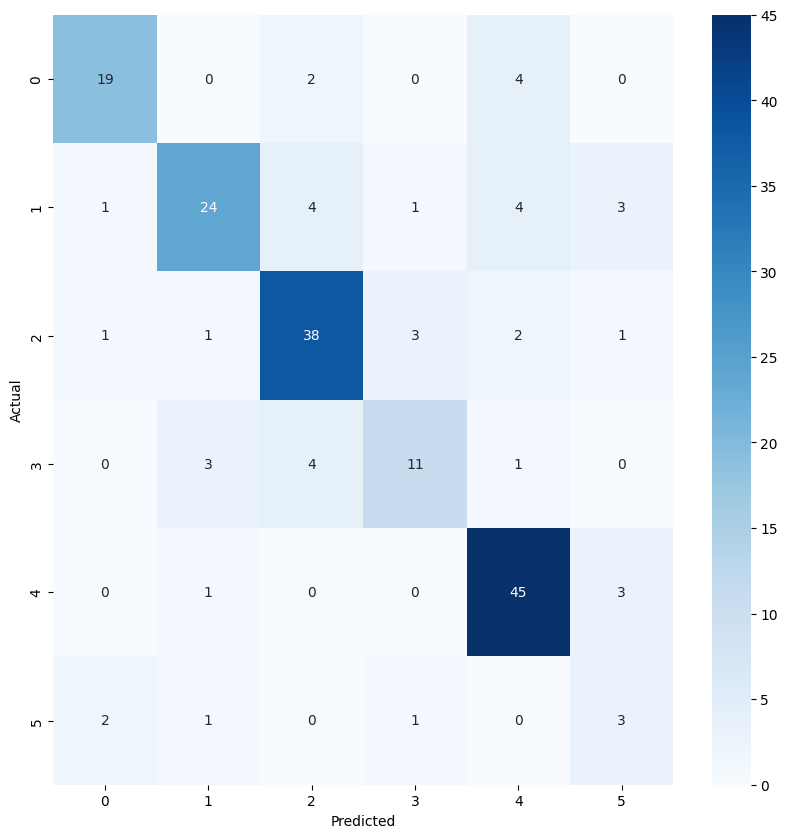

In [ ]:
print("GPU 메모리 해제")
torch.cuda.empty_cache()

print("CUDA 정보")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# 모델 및 데이터로더 설정
model_names = ['klue/roberta-base', 'klue/roberta-large']
num_epochs = 10
batch_size = 16
max_len = 128

trained_models = []
tokenizers = []

for model_name in model_names:
    print(f"Training {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)  # 정확한 repo_id 사용
    train_loader = create_data_loader(balanced_df, tokenizer, max_len, batch_size)
    test_loader = create_data_loader(test_df, tokenizer, max_len, batch_size)
    model = train_model(train_loader, test_loader, model_name, num_epochs, batch_size)
    trained_models.append(model)
    tokenizers.append(tokenizer)

print("앙상블 예측 실행")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_preds = ensemble_predict_weighted(trained_models, tokenizers, test_df, device)

# 결과 평가
accuracy = accuracy_score(test_df.section, ensemble_preds)
f1 = f1_score(test_df.section, ensemble_preds, average='macro')

print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble F1 Score: {f1}')

# 혼동 행렬 시각화
cm = confusion_matrix(test_df.section, ensemble_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
sect_dic = {0: "정치", 1: "경제", 2: "사회", 3: "생활/문화", 4: "세계", 5: "IT/과학"}

for i in range(10):  # 처음 10개 예측 결과 출력
    print(f"기사: {test_df.iloc[i].title}")
    print(f"예측된 섹션: {sect_dic[ensemble_preds[i]]}")
    print(f"실제 섹션: {sect_dic[test_df.section.iloc[i]]}")
    print()

기사: 원주시, 취약층 여름나기 점검 완료
예측된 섹션: 세계
실제 섹션: 사회

기사: 유엔 “가자 인도주의 구역 대피령에 하루 새 15만명 탈출”
예측된 섹션: 세계
실제 섹션: 세계

기사: 野, 교사 업무 ‘수업·연구’에 한정… 행정직원들 반발
예측된 섹션: 세계
실제 섹션: 사회

기사: 독일 기후단체 '접착제 시위' 공항 3시간 마비
예측된 섹션: 세계
실제 섹션: 세계

기사: 北 오물풍선에 대통령실도 뚫려… 軍, 대북전광판 재설치 할수도
예측된 섹션: 세계
실제 섹션: 정치

기사: [Biz & Now] 농심, 파리에 신라면 팝업스토어 오픈
예측된 섹션: 세계
실제 섹션: 경제

기사: 위메프 피해자 본사 항의…새벽 3시 일부 환불
예측된 섹션: 세계
실제 섹션: 사회

기사: 평창군, 2024 평창더위사냥축제 준비 한창
예측된 섹션: 세계
실제 섹션: 사회

기사: 이재명 "탄핵, 국민이 결정할 사안…대통령 되면 개헌하려 했다"
예측된 섹션: 세계
실제 섹션: 정치

기사: 김민기 발인…‘아침이슬’과 함께 옛 학전에 마지막 인사
예측된 섹션: 세계
실제 섹션: 생활/문화



In [ ]:
import torch
import gc

def gpu_memory_reset():
    # 현재 GPU 장치 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # GPU 캐시 초기화
    torch.cuda.empty_cache()

    # Python의 garbage collector 호출
    gc.collect()

    # PyTorch CUDA 캐시 초기화
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

# GPU 메모리 초기화 함수 호출
gpu_memory_reset()

print("GPU 메모리 초기화 완료")


GPU 메모리 초기화 완료


In [ ]:

# 새로운 데이터 파일 로드
new_data_path = '/content/naver_news_content_20240722.xlsx'
new_data_df = pd.read_excel(new_data_path)

# Combine the title and content for prediction
new_data_df['text'] = new_data_df['뉴스제목'] + ' ' + new_data_df['본문']
new_data_df = new_data_df[['뉴스제목', '본문', 'text']]  # Include 뉴스제목 and 본

# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# 모델 이름 정의
model_names = ['klue/roberta-base', 'klue/roberta-large']
trained_models = []
tokenizers = []

# 모델과 토크나이저 로드
for model_name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
    model = model.to(device)
    trained_models.append(model)
    tokenizers.append(tokenizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 새로운 데이터에 대한 데이터셋 클래스 정의
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 새로운 데이터를 위한 데이터 로더 생성 함수
def create_new_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df['text'].to_numpy(),  # 데이터프레임에서 텍스트 열 사용
        labels=[0]*len(df),  # 더미 라벨 사용
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=8)  #cpu 8대인 가상 공간에서 진행 중


In [ ]:
# 새로운 데이터를 데이터 로더에 로드
new_data_loaders = [create_new_data_loader(new_data_df, tokenizer, max_len=128, batch_size=16) for tokenizer in tokenizers]


In [ ]:
# 예측 수행 함수
def predict(models, data_loaders, device):
    all_predictions = []
    for model, data_loader in zip(models, data_loaders):
        model.eval()
        predictions = []
        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        all_predictions.append(predictions)
    return all_predictions

# 예측 결과 얻기
all_preds = predict(trained_models, new_data_loaders, device)


In [ ]:
# 예측 결과 얻기
all_preds = predict(trained_models, new_data_loaders, device)

In [ ]:
# 예측 결과 앙상블
from scipy.stats import mode
ensemble_preds = mode(all_preds, axis=0)[0].flatten()
new_data_df['predicted_label'] = ensemble_preds


In [ ]:
# 라벨을 섹션 이름으로 매핑
sect_dic = {0: "정치", 1: "경제", 2: "사회", 3: "생활/문화", 4: "세계", 5: "IT/과학"}
new_data_df['predicted_section'] = new_data_df['predicted_label'].map(sect_dic)

# 라벨링된 데이터를 엑셀 파일로 저장
output_path = '/content/labeled_news_data.xlsx'
new_data_df.to_excel(output_path, index=False)

In [ ]:
import os
import re

# 라벨링된 데이터 파일 로드
labeled_data_path = '/content/labeled_news_data.xlsx'
labeled_data_df = pd.read_excel(labeled_data_path)

# 저장할 디렉토리 경로 설정
output_dir = '/content/labeled_news_data/'

# 디렉토리가 존재하지 않으면 생성
os.makedirs(output_dir, exist_ok=True)

def safe_filename(filename):
    # 파일 이름에서 안전하지 않은 문자를 제거
    return re.sub(r'[^a-zA-Z0-9가-힣]', '_', filename)

for section in sections:
    section_df = labeled_data_df[labeled_data_df['predicted_section'] == section]
    safe_section = safe_filename(section)
    section_filename = os.path.join(output_dir, f'labeled_news_data_{safe_section}.xlsx')
    section_df[['뉴스제목', '본문', 'predicted_section']].to_excel(section_filename, index=False)  # Include the required columns
    print(f'Saved {section} data to {section_filename}')
# 저장된 파일 리스트 출력
saved_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]
for file in saved_files:
    print(file)



Saved 경제 data to /content/labeled_news_data/labeled_news_data_경제.xlsx
Saved 생활/문화 data to /content/labeled_news_data/labeled_news_data_생활_문화.xlsx
/content/labeled_news_data/labeled_news_data_생활_문화.xlsx
/content/labeled_news_data/labeled_news_data_경제.xlsx
/content/labeled_news_data/.ipynb_checkpoints
